In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime as dt
from wordcloud import WordCloud, STOPWORDS
from os import path
from scipy.misc import imread

# Load data

In [2]:
df = pd.read_json('./data/train.json')
df.created = pd.to_datetime(df.created)
df['created_date'] = [d.date() for d in df.created]
print(df.shape)
df.head(3)

(49352, 16)


,bathrooms,bedrooms,building_id,created,description,display_address,features,interest_level,latitude,listing_id,longitude,manager_id,photos,price,street_address,created_date
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],medium,40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,2016-06-24
10000,1.0,2,c5c8a357cba207596b04d1afd1e4f130,2016-06-12 12:19:27,,Columbus Avenue,"[Doorman, Elevator, Fitness Center, Cats Allow...",low,40.7947,7150865,-73.9667,7533621a882f71e25173b27e3139d83d,[https://photos.renthop.com/2/7150865_be3306c5...,5465,808 Columbus Avenue,2016-06-12
100004,1.0,1,c3ba40552e2120b0acfc3cb5730bb2aa,2016-04-17 03:26:41,"Top Top West Village location, beautiful Pre-w...",W 13 Street,"[Laundry In Building, Dishwasher, Hardwood Flo...",high,40.7388,6887163,-74.0018,d9039c43983f6e564b1482b273bd7b01,[https://photos.renthop.com/2/6887163_de85c427...,2850,241 W 13 Street,2016-04-17


# Clean descriptions

In [3]:
sentence = list(df['description'])[0]
print('=== Raw sentence:\n',sentence)
tokens = [word.lower() for sent in nltk.sent_tokenize(sentence) for word in nltk.word_tokenize(sent)]
print('=== Raw tokens:\n',tokens)
skip_tokens = ['<','br','/','>','a','p','il','website_reducted']
clear_tokens = list(filter(lambda s:  s not in skip_tokens,tokens))
print('=== Filtered tokens:\n',clear_tokens)

=== Raw sentence:
 A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy These Following Apartment Features As You Rent Here? Modern Designed Bathroom w/ a Deep Spa Soaking Tub? Room to Room AC/Heat? Real Oak Hardwood Floors? Rain Forest Shower Head? SS steel Appliances w/ Chef Gas Cook Oven & LG Fridge? washer /dryer in the apt? Cable Internet Ready? Granite Counter Top Kitchen w/ lot of cabinet storage spaceIt's Just A Few blocks To L Train<br /><br />Don't miss out!<br /><br />We have several great apartments in the immediate area.<br /><br />For additional information 687-878-2229<p><a  website_redacted 


NameError: name 'nltk' is not defined

# http://brandonrose.org/clustering

In [4]:
import nltk
from nltk.stem.snowball import SnowballStemmer
stopwords = nltk.corpus.stopwords.words('english')
stemmer = SnowballStemmer("english")
print(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers', 'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'no

In [5]:
import re
skip_tokens = ['<','br','/','>','a','p','il','website_redacted','kagglemanager'] + nltk.corpus.stopwords.words('english')


def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    clear_tokens = list(filter(lambda s:  s not in skip_tokens,tokens))
    for token in clear_tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return list(set(stems))


#def tokenize_only(text):
#    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
#    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
#    filtered_tokens = []
#    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
#    for token in tokens:
#        if re.search('[a-zA-Z]', token):
#            filtered_tokens.append(token)
#    return filtered_tokens

In [6]:
sentences = list(df['description'][:1000])
totalvocab_stemmed = []
totalvocab_tokenized = []
for s in sentences:
    allwords_stemmed = tokenize_and_stem(s) #for each item in 'synopses', tokenize/stem
    totalvocab_stemmed.extend(allwords_stemmed) #extend the 'totalvocab_stemmed' list
    
    #allwords_tokenized = tokenize_only(s)
    #totalvocab_tokenized.extend(allwords_tokenized)

In [7]:
#vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
vocab_frame = pd.DataFrame({'words': totalvocab_stemmed}, index = totalvocab_stemmed)

print('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 57107 items in vocab_frame


In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer

#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(sentences) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

CPU times: user 2.65 s, sys: 23 ms, total: 2.67 s
Wall time: 2.68 s
(1000, 41)


In [31]:
pd.DataFrame(tfidf_matrix.toarray(),columns=tfidf_vectorizer.get_feature_names())

,apart,applianc,bathroom,beauti,bedroom,broker,build,ceil,closet,contact,...,renthop.com,restaur,room,shop,space,stainless,steel,unit,view,window
0,0.216203,0.271226,0.313412,0.000000,0.239913,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.293004,0.000000,0.000000,0.000000,0.286940,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.143865,0.000000,0.208550,0.229846,0.159643,0.238607,0.161550,0.000000,0.195799,0.213105,...,0.000000,0.217193,0.194971,0.000000,0.000000,0.000000,0.000000,0.000000,0.177693,0.000000
3,0.202468,0.000000,0.000000,0.000000,0.000000,0.000000,0.227356,0.000000,0.000000,0.000000,...,0.000000,0.305665,0.274390,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.193769,0.243083,0.280891,0.309574,0.215019,0.000000,0.217587,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.254013,0.257166,0.310652,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.228661,0.000000,0.277138,0.301634,...,0.277138,0.307420,0.000000,0.335886,0.000000,0.266941,0.000000,0.326462,0.000000,0.000000
7,0.154243,0.193498,0.000000,0.246426,0.000000,0.000000,0.173203,0.000000,0.209923,0.000000,...,0.000000,0.232860,0.000000,0.254422,0.216051,0.202199,0.204708,0.000000,0.190511,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.173021,0.000000,0.000000,0.000000,0.191996,0.286963,0.000000,0.269460,0.235479,0.000000,...,0.000000,0.261210,0.234483,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.260792


In [29]:
terms = tfidf_vectorizer.get_feature_names()
print(terms)
print(len(terms))

['apart', 'applianc', 'bathroom', 'beauti', 'bedroom', 'broker', 'build', 'ceil', 'closet', 'contact', 'dishwash', 'doorman', 'email', 'featur', 'fit', 'floor', 'granit', 'great', 'hardwood', 'high', 'includ', 'kitchen', 'larg', 'laundri', 'light', 'live', 'locat', 'marbl', 'new', 'park', 'renov', 'renthop.com', 'restaur', 'room', 'shop', 'space', 'stainless', 'steel', 'unit', 'view', 'window']
41


In [10]:
from sklearn.metrics.pairwise import cosine_similarity
%time dist = 1 - cosine_similarity(tfidf_matrix)

CPU times: user 34 ms, sys: 13 ms, total: 46.9 ms
Wall time: 46.2 ms


In [11]:
from sklearn.cluster import KMeans

num_clusters = 5

km = KMeans(n_clusters=num_clusters)

%time km.fit(tfidf_matrix)

clusters = km.labels_.tolist()

CPU times: user 1.36 s, sys: 6.23 ms, total: 1.37 s
Wall time: 1.37 s


In [12]:
from sklearn.externals import joblib

#uncomment the below to save your model 
#since I've already run my model I am loading from the pickle

joblib.dump(km,  'doc_cluster.pkl')

km = joblib.load('doc_cluster.pkl')
clusters = km.labels_.tolist()

In [13]:
#films = { 'title': titles, 'rank': ranks, 'synopsis': synopses, 'cluster': clusters, 'genre': genres }

#frame = pd.DataFrame(films, index = [clusters] , columns = ['rank', 'title', 'cluster', 'genre'])

In [14]:
#from __future__ import print_function

print("Top terms per cluster:")
print()
#sort cluster centers by proximity to centroid
order_centroids = km.cluster_centers_.argsort()[:, ::-1] 

for i in range(num_clusters):
    print("Cluster %d words:" % i, end='')
    
    for ind in order_centroids[i, :10]: #replace 6 with n words per cluster
        print(' %s' % vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'), end=',')
    print() #add whitespace
    print() #add whitespace
    
    #print("Cluster %d titles:" % i, end='')
    #for title in frame.ix[i]['title'].values.tolist():
    #    print(' %s,' % title, end='')
    #print() #add whitespace
    #print() #add whitespace
    
print()
print()

Top terms per cluster:

Cluster 0 words: b'doorman', b'laundri', b'room', b'build', b'view', b'contact', b'fit', b'renthop.com', b'apart', b'kitchen',

Cluster 1 words: b'steel', b'stainless', b'applianc', b'kitchen', b'floor', b'hardwood', b'granit', b'apart', b'marbl', b'bedroom',

Cluster 2 words: b'broker', b'new', b'apart', b'renthop.com', b'contact', b'email', b'bedroom', b'locat', b'great', b'view',

Cluster 3 words: b'locat', b'kitchen', b'apart', b'space', b'live', b'bedroom', b'restaur', b'floor', b'great', b'shop',

Cluster 4 words: b'apart', b'bedroom', b'floor', b'build', b'renov', b'great', b'locat', b'contact', b'larg', b'featur',





In [15]:
cluster_colors = {0: '#1b9e77', 1: '#d95f02', 2: '#7570b3', 3: '#e7298a', 4: '#66a61e'}

#set up cluster names using a dict
cluster_names = {2: 'Great,beauti', 
                 3: 'Furnished', 
                 0: 'Parameters', 
                 1: 'Materials', 
                 4: 'Neutral'}

In [16]:
import os  # for os.path.basename

import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.manifold import MDS

MDS()

# convert two components as we're plotting points in a two-dimensional plane
# "precomputed" because we provide a distance matrix
# we will also specify `random_state` so the plot is reproducible.
mds = MDS(n_components=2, dissimilarity="precomputed", random_state=1)

%time pos = mds.fit_transform(dist)  # shape (n_components, n_samples)

xs, ys = pos[:, 0], pos[:, 1]

CPU times: user 1min 38s, sys: 9.18 s, total: 1min 48s
Wall time: 27.2 s


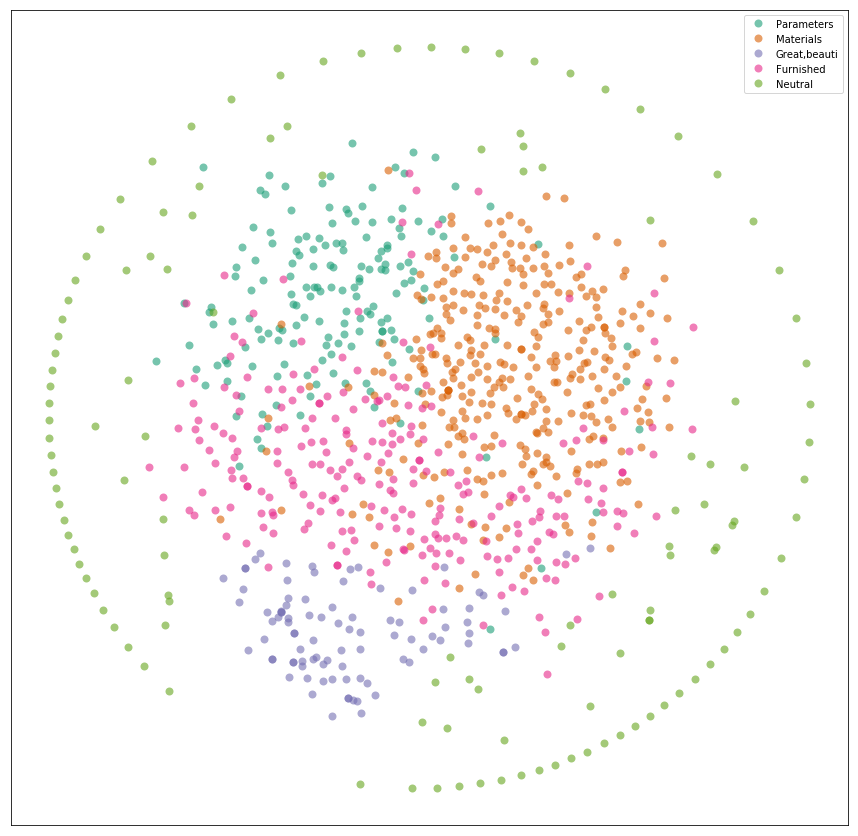

In [17]:
#some ipython magic to show the matplotlib plots inline
%matplotlib inline 

#create data frame that has the result of the MDS plus the cluster numbers and titles
df = pd.DataFrame(dict(x=xs, y=ys, label=clusters))#, title=titles)) 

#group by cluster
groups = df.groupby('label')


# set up plot
fig, ax = plt.subplots(figsize=(15, 15)) # set size
ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

#iterate through groups to layer the plot
#note that I use the cluster_name and cluster_color dicts with the 'name' lookup to return the appropriate color/label
for name, group in groups:
    ax.plot(group.x, group.y, marker='o', linestyle='', ms=8, 
            label=cluster_names[name], color=cluster_colors[name], alpha=0.6,
            mec='none')
    ax.set_aspect('auto')
    ax.tick_params(\
        axis= 'x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelbottom='off')
    ax.tick_params(\
        axis= 'y',         # changes apply to the y-axis
        which='both',      # both major and minor ticks are affected
        left='off',      # ticks along the bottom edge are off
        top='off',         # ticks along the top edge are off
        labelleft='off')
    
ax.legend(numpoints=1)  #show legend with only 1 point

#add label in x,y position with the label as the film title
#for i in range(len(df)):
#    ax.text(df.ix[i]['x'], df.ix[i]['y'], int(df.ix[i]['label']), size=8)  

    
    
plt.show() #show the plot

#uncomment the below to save the plot if need be
#plt.savefig('clusters_small_noaxes.png', dpi=200)